# **Machine Learning Engineer Coding Challenge at N Brown Group (v0.1.0)**

## Instructions

 1. Create a Databricks community edition and import this notebook
 1. Attempt the problems below within the allotted time frame. Some challenges may be more advanced than others and could require additional time. We expect candidates to spend about 2 hours completing all tasks.
 1. You are free to use `any programming language` (Python, SQL, Scala, etc.) to solve the challenges.
 1. Ensure that your notebooks with code in them are well-organized and capable of successful execution.
 1. Upon completion, publish your notebook(s) by selecting the `Publish` option from the File menu.
 1. Email the URL(s) of your published notebook(s) back to your N Brown contact Qiang MENG (qiang.meng@nbrown.co.uk)

In case of any questions, please contact Qiang Meng or Shafiq Kyazze. Thank you for your participation and effort in this coding challenge. 

## Tips
- The Databricks Guide (at the top of the Workspace) provides examples of how to use Databricks. You may want to start by reading through it [here](https://docs.databricks.com/en/notebooks/index.html)


## Challenge I
---

### Industrialise Data Science code
- Format the code below to make it ready for production by following Software engineering and Python best practises.

In [0]:
# %%
import pandas as pd
import pytest
import numpy as np
pd.set_option('display.max_columns', None)


# %%
name_format = {'Age in Qtrs':'age_in_quarter',
'CohortID':'cohort_id',
'cohort_age_in_quarter': 'age_in_quarter',
'inQtr Base AOF':'in_qtr_base_aof',
'inQtr Base AOV':'in_qtr_base_aov',
'inQtr Base Churn': 'in_qtr_base_churn_rate',
'inQtr Base DPOA': 'in_qtr_base_dpoa',
'inQtr Base ReTrade':'in_qtr_base_retrade_rate',
'inQtr Returning AOF': 'in_qtr_returning_aof',
'inQtr Returning AOV': 'in_qtr_returning_aov',
'inQtr Returning DPOA': 'in_qtr_returning_dpoa',
'inQtr Returning Rate': 'in_qtr_returning_rate',
'inYear Base AOF': 'in_year_base_aof',
'inYear Base DPOA': 'in_year_base_dpoa',
'inYear Base Retained': 'in_year_base_retention_rate',
'inYear New DPOA':'in_year_new_dpoa',
'inYear Returning AOF':'in_year_base_returning_aof',
'inYear Returning DPOA':'in_year_base_returning_dpoa',
'inYear Returning Rate':'in_year_base_returning_rate',
'recruitment_quarter': 'first_qtr'}

def format_columns(df, name_format):
    new_cols = []
    for name in df.columns:
        if name in name_format.keys():
            new_cols.append(name_format[name])
        else:
            new_cols.append(name)

    df.columns = new_cols

    if 'cohort_id' not in df.columns:
        df['cohort_id'] =  df['brand'] + df['migrated'] + df['cashcredit'] + df['first_qtr']



    df['rw_id'] = df.cohort_id + df.outcome_ends

    all_cols = df.columns.sort_values()
    df = df[all_cols]

    #df.index = df['rw_id']


    return(df)


def get_period(string):
    if 'Q' in string:
        return(pd.Period('20' + string.split('FY')[1][2:].strip(), freq = 'Q-FEB'))
    else:
        return(pd.Period('20' + string.split('FY')[1][2:].strip() + 'Q1', freq = 'Q-FEB'))

# %%
sql_output = pd.read_csv('dev/sql/actuals.csv')
sql_output = format_columns(sql_output)
sql_types = sql_output.dtypes.to_dict() # extract datatypes from sql output - use this to format our sanity datatypes
#TODO: need to adjust mapping of names from previous cell

sanity = pd.read_csv('dev/original_excel/full_sanity.csv')
sanity = format_columns(sanity)
sanity.replace('#DIV/0!', np.nan, inplace=True)
sanity = sanity.astype(sql_types)


#NOTE: our sanity check contains `inYear New AOF`. This is not vital to our calculations, but should still be looked into.

# %%
sanity['outcome_ends'].value_counts()

# %%
sql_output['outcome_ends'].value_counts()

# %%
def get_agefrm(df):
    df_agefrm = df.loc[:, ['outcome_ends', 'first_qtr', 'brand', 'age_in_quarter']]
    df_agefrm['oe'] = [get_period(i) for i in df_agefrm['outcome_ends']]
    df_agefrm['fq'] = [get_period(i) for i in df_agefrm['first_qtr']]
    df_agefrm['calc_age'] = df_agefrm['oe'] - df_agefrm['fq']
    df_agefrm['calc_age'] = [i.n +1 for i in df_agefrm['calc_age']]
    df_agefrm['age_diff'] = abs(df_agefrm['age_in_quarter'] - df_agefrm['calc_age'])
    return(df_agefrm)


sql_agefrm = get_agefrm(sql_output)
sanity_agefrm = get_agefrm(sanity)

#sql_agefrm[sql_agefrm.age_diff >10] = 0

# %%
sanity_agefrm.age_diff.value_counts()

# %%


# %%
sql_agefrm.age_diff.value_counts()[1:].sum()

# %%
sql_agefrm

# %%
sql_agefrm[sql_agefrm.age_diff > 0].first_qtr.value_counts()

# %%
sql_output.loc[:, ['outcome_ends', 'first_qtr', 'brand', 'age_in_quarter', 'outcome_ends']]

# %%
sql_agefrm

# %%
sql_agefrm[(sql_agefrm.age_diff > 0)].first_qtr.value_counts()

# %%
sql_agefrm.loc[:, 'age_diff'].plot.bar()

# %%
sql_agefrm

# %%
import matplotlib.pyplot as plt

plt.scatter(sql_agefrm['calc_age'], sql_agefrm['age_diff'])

# %%
sql_agefrm[sql_agefrm.calc_age != sql_agefrm.age_in_quarter].brand.unique()

# %%
sanity.in_qtr_base_aof.dtypes

# %%
np.seterr(invalid="ignore")

for id in sanity['rw_id'].unique():
    sanity_row = sanity.loc[sanity.rw_id == id,:]
    sql_row = sql_output.loc[sql_output.rw_id == id,:]
    for column in sql_row.columns:
        if column == 'in_year_base_returning_aof':
            pass
        elif sanity_row[column].dtypes != ('float64') and sanity_row[column].dtypes != ('int64'):
                try:
                    assert sanity_row[column].values == sql_row[column].values
                except AssertionError as e:
                    print(f'{column} \t {id}')
                    print(f'{sanity_row[column].values} \t {sql_row[column].values}')
        else:
            try:
                if (sanity_row[column].values[0] - sql_row[column].values[0])/sanity_row[column].values[0] > 0.1:
                    print(f'{column} \t {id}')
                    print(f'{sanity_row[column].values} \t {sql_row[column].values}')
            except Exception as e:
                pass

# %%
#out = pd.concat([sanity, sql_output], join = 'inner')

joined = pd.merge(sanity, sql_output, how = 'outer', on= 'rw_id', suffixes=('_sanity', '_sql'))
joined.index = joined.rw_id

# %%
36/4

# %%
def diff_ser(col):
    return(abs(joined[f'{col}_sanity'] - joined[f'{col}_sql']))

diff_ser('age_in_quarter').value_counts()#[diff_ser('age_in_quarter')]


# %%
i.index.split('FY')[1] for i in diff_ser('age_in_quarter').index.split('FY')[1]

# %%
[i.split('FY')[1] for i in inds]

# %%
len(out.columns) == out.columns.nunique()

# %%
sql_output.join(sanity, on= 'rw_id', how= 'outer')

# %%
import numpy as np
sanity.dtypes[sanity.dtypes == 'object']

to_int =['in_year_base_aof',
'in_year_base_dpoa',
'in_year_base_retention_rate',
'in_year_base_returning_aof',
'in_year_base_returning_dpoa',
'in_year_base_returning_rate']

for i in to_int:
    sanity[i] = sanity[i].replace('#DIV/0!', np.nan)
    sanity[i] = sanity[i].astype('float64')

# %%
id

# %%
sanity_row[column].values== pytest.approx(sql_row[column].values, 0.1)

# %%
set(sanity.columns).symmetric_difference(set(sql_output.columns))


Challenge 1:
The Industrialise Data Science code

In [0]:
# Standard library imports
import numpy as np
import pandas as pd
import pytest  # Used for unit testing functions 

# Set display options for pandas DataFrames to improve readability in output
pd.set_option('display.max_columns', None)


In [0]:
# Define a mapping of original column names to standardized column names
COLUMN_NAME_MAPPING = {
    'Age in Qtrs': 'age_in_quarter',
    'CohortID': 'cohort_id',
    'cohort_age_in_quarter': 'age_in_quarter',  # Consider consolidating similar names if possible
    'inQtr Base AOF': 'in_qtr_base_aof',
    'inQtr Base AOV': 'in_qtr_base_aov',
    'inQtr Base Churn': 'in_qtr_base_churn_rate',
    'inQtr Base DPOA': 'in_qtr_base_dpoa',
    'inQtr Base ReTrade': 'in_qtr_base_retrade_rate',
    'inQtr Returning AOF': 'in_qtr_returning_aof',
    'inQtr Returning AOV': 'in_qtr_returning_aov',
    'inQtr Returning DPOA': 'in_qtr_returning_dpoa',
    'inQtr Returning Rate': 'in_qtr_returning_rate',
    'inYear Base AOF': 'in_year_base_aof',
    'inYear Base DPOA': 'in_year_base_dpoa',
    'inYear Base Retained': 'in_year_base_retention_rate',
    'inYear New DPOA': 'in_year_new_dpoa',
    'inYear Returning AOF': 'in_year_base_returning_aof',
    'inYear Returning DPOA': 'in_year_base_returning_dpoa',
    'inYear Returning Rate': 'in_year_base_returning_rate',
    'recruitment_quarter': 'first_qtr'
}


In [0]:
def format_and_augment_columns(df, column_mapping):
    """Renames DataFrame columns based on a mapping and augments additional columns.

    Args:
        df (pd.DataFrame): The DataFrame to modify.
        column_mapping (dict): A dictionary mapping original column names to new names.

    Returns:
        pd.DataFrame: The modified DataFrame with renamed and new columns.
    """
    # Rename columns using the provided mapping
    df.rename(columns=column_mapping, inplace=True)

    # Ensure all required new columns are present and create them if not
    if 'cohort_id' not in df.columns:
        # Check for required columns before trying to create 'cohort_id'
        required_columns = ['brand', 'migrated', 'cashcredit', 'first_qtr']
        if all(col in df.columns for col in required_columns):
            df['cohort_id'] = df['brand'].astype(str) + df['migrated'].astype(str) + \
                              df['cashcredit'].astype(str) + df['first_qtr'].astype(str)
        else:
            missing = [col for col in required_columns if col not in df.columns]
            raise ValueError(f"Missing required columns for 'cohort_id' calculation: {missing}")

    # Create a row identifier if necessary
    if 'outcome_ends' in df.columns and 'cohort_id' in df.columns:
        df['rw_id'] = df['cohort_id'] + df['outcome_ends']
    else:
        raise ValueError("Required columns for 'rw_id' are missing.")

    # Sort columns for a uniform DataFrame structure
    df = df.reindex(sorted(df.columns), axis=1)

    return df


In [0]:
def get_period(fiscal_string):
    """Converts a fiscal year and quarter string to a pandas Period object.
    
    Args:
        fiscal_string (str): A string representing the fiscal year and quarter, e.g., 'FY21Q1'.

    Returns:
        pd.Period: A period object representing the fiscal quarter.

    Raises:
        ValueError: If the input string is not formatted as expected.
    """
    try:
        year_part = fiscal_string.split('FY')[1]  # Expecting the format 'FYxxQx'
        year = '20' + year_part[:2]
        quarter = year_part[2:].strip() if 'Q' in year_part else 'Q1'
        return pd.Period(year + quarter, freq='Q-FEB')
    except (IndexError, ValueError) as e:
        raise ValueError(f"Input string {fiscal_string} is not formatted correctly: {str(e)}")


In [0]:
def calculate_age_differences(df):
    """Calculate the differences in ages based on fiscal periods and add results to the DataFrame.

    Args:
        df (pd.DataFrame): Input DataFrame with columns 'outcome_ends' and 'first_qtr'.

    Returns:
        pd.DataFrame: DataFrame with additional columns for period calculations and age differences.
    """
    # Ensure required columns are present
    if not {'outcome_ends', 'first_qtr', 'age_in_quarter'}.issubset(df.columns):
        raise ValueError("Missing required columns for calculating age differences.")

    try:
        # Apply the get_period function and handle exceptions if any
        df['period_outcome'] = df['outcome_ends'].apply(get_period)
        df['period_first_qtr'] = df['first_qtr'].apply(get_period)
        
        # Calculate the period differences and the resulting age adjustments
        df['calculated_age'] = (df['period_outcome'] - df['period_first_qtr']).apply(lambda p: p.n + 1)
        df['age_difference'] = abs(df['age_in_quarter'] - df['calculated_age'])
    except Exception as e:
        raise RuntimeError(f"Failed to calculate age differences: {str(e)}")
    
    return df


In [0]:
import matplotlib.pyplot as plt

def plot_age_difference_histogram(df):
    """Plot a histogram of age differences in the dataset.

    Args:
        df (pd.DataFrame): DataFrame containing the 'age_diff' column.
    """
    plt.figure(figsize=(12, 6))
    df['age_diff'].plot(kind='bar', color='skyblue')
    plt.title('Age Difference Histogram')
    plt.xlabel('Index')
    plt.ylabel('Age Difference')
    plt.grid(True)
    plt.show()

def plot_age_vs_difference_scatter(df):
    """Plot a scatter diagram comparing calculated ages to their respective age differences.

    Args:
        df (pd.DataFrame): DataFrame containing 'calc_age' and 'age_diff' columns.
    """
    plt.figure(figsize=(12, 6))
    plt.scatter(df['calc_age'], df['age_diff'], alpha=0.5, color='magenta')
    plt.title('Calculated Age vs Age Difference')
    plt.xlabel('Calculated Age')
    plt.ylabel('Age Difference')
    plt.grid(True)
    plt.show()


In [0]:
def compare_datasets(df1, df2, key):
    """Compare two dataframes row by row based on a key to find mismatches.

    Args:
        df1 (pd.DataFrame): First DataFrame.
        df2 (pd.DataFrame): Second DataFrame to compare against.
        key (str): The key column on which to join and compare the DataFrames.
    """
    merged_df = pd.merge(df1, df2, on=key, suffixes=('_df1', '_df2'))
    for column in merged_df.columns:
        if '_df1' in column:
            col_df2 = column.replace('_df1', '_df2')
            if not merged_df[column].equals(merged_df[col_df2]):
                print(f"Mismatch found in {column} for rows where {key} matches.")


In [0]:
def merge_dataframes(df1, df2, key, how='outer'):
    """Merge two DataFrames based on a specified key.

    Args:
        df1 (pd.DataFrame): First DataFrame.
        df2 (pd.DataFrame): Second DataFrame.
        key (str): Key column for merging.
        how (str): Type of merge to perform.

    Returns:
        pd.DataFrame: The resulting merged DataFrame.
    """
    merged = pd.merge(df1, df2, how=how, on=key, suffixes=('_df1', '_df2'))
    return merged.set_index(key)


In [0]:
def main():
    try:
        # Load data
        sql_output = pd.read_csv('dev/sql/actuals.csv')
        sanity = pd.read_csv('dev/original_excel/full_sanity.csv')

        # Apply transformations
        sql_output = format_and_augment_columns(sql_output, COLUMN_NAME_MAPPING)
        sanity = format_and_augment_columns(sanity, COLUMN_NAME_MAPPING)
        sanity.replace('#DIV/0!', np.nan, inplace=True)
        sanity = sanity.astype(sql_output.dtypes.to_dict())

        # Calculate age differences
        sql_agefrm = calculate_age_differences(sql_output)
        sanity_agefrm = calculate_age_differences(sanity)

        # Visualize data
        plot_age_difference_histogram(sql_agefrm)
        plot_age_vs_difference_scatter(sql_agefrm)

        # Compare datasets
        compare_datasets(sanity, sql_output, 'rw_id')

        # Merge dataframes
        joined_df = merge_dataframes(sanity, sql_output, 'rw_id')
        joined_df.to_csv('output/joined_output.csv', index=False)
        print("Process completed successfully and output file saved.")

    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()


Workflow Structure: The main() function encapsulates the entire data processing workflow, ensuring each step is clearly defined and logically ordered.
Error Handling: Includes a broad try-except block to catch and report errors that might occur at any stage of the process. For a production environment, you might want to handle specific exceptions more granularly and possibly log them instead of printing.
Output: Saves the merged DataFrame to a CSV file, providing a tangible output from the process.
Comprehensive Testing:
Unit Testing: Each function (like format_and_augument_columns, calculate_age_differences, etc.) should be unit tested separately to ensure it behaves as expected with various inputs. This involves mocking inputs and asserting outputs.

Integration Testing: Test the script as a whole to ensure that components interact correctly and the overall functionality meets the requirements. This might involve testing with a full dataset or a representative subset.

Validation: Confirm that the final outputs (e.g., visualizations and CSV files) are correct and useful, checking both the content and format.

## Challenge II
--- 

### Data Processing 

This Baby Names dataset comes from a website referenced by [Data.gov](http://catalog.data.gov/dataset). It lists baby names used in the state of New York from 2007 to 2012.

**Question**: 

`What is the most popular first letter for baby names for each given year in the dataset?`

Tips: What does the nested schema of this json dataset look like? How can you bring these nested fields up to the top level in a tabuler DataFrame?
The following cells run commands that copy this file to the cluster.

In [0]:
%scala
import java.net.URL
import java.io.File
import org.apache.commons.io.FileUtils

val tmpFile = new File("/tmp/rows.json")
FileUtils.copyURLToFile(new URL("https://health.data.ny.gov/api/views/jxy9-yhdk/rows.json?accessType=DOWNLOAD"), tmpFile)

In [0]:
%fs head file:/tmp/rows.json

[Truncated to first 65536 bytes]
{
 "meta" : {
 "view" : {
 "id" : "jxy9-yhdk",
 "name" : "Baby Names: Beginning 2007",
 "assetType" : "dataset",
 "attribution" : "New York State Department of Health",
 "attributionLink" : "http://www.health.ny.gov/statistics/vital_statistics/",
 "averageRating" : 0,
 "category" : "Health",
 "createdAt" : 1356724562,
 "description" : "New York State Baby Names are aggregated and displayed by the year, county, or borough where the mother resided as stated on a New York State or New York City (NYC) birth certificate. The frequency of the baby name is listed if there are 5 or more of the same baby name in a county outside of NYC or 10 or more of the same baby name in a NYC borough.",
 "displayType" : "table",
 "downloadCount" : 121792,
 "hideFromCatalog" : false,
 "hideFromDataJson" : false,
 "locked" : false,
 "newBackend" : true,
 "numberOfComments" : 0,
 "oid" : 40162507,
 "provenance" : "official",
 "publicationAppendEnabled" : false,
 "publicationDate" : 1699650435,
 "publicationGroup" : 583607,
 "publicationStage" : "published",
 "rowClass" : "",
 "rowsUpdatedAt" : 1699650496,
 "rowsUpdatedBy" : "a9xd-f5um",
 "tableId" : 19360462,
 "totalTimesRated" : 0,
 "viewCount" : 84464,
 "viewLastModified" : 1699650490,
 "viewType" : "tabular",
 "approvals" : [ {
 "reviewedAt" : 1527713207,
 "reviewedAutomatically" : true,
 "state" : "approved",
 "submissionId" : 5912825,
 "submissionObject" : "public_audience_request",
 "submissionOutcome" : "change_audience",
 "submittedAt" : 1527713207,
 "targetAudience" : "public",
 "workflowId" : 1966,
 "submissionDetails" : {
 "permissionType" : "READ"
 },
 "submissionOutcomeApplication" : {
 "failureCount" : 0,
 "status" : "success"
 },
 "submitter" : {
 "id" : "s9j2-nqmr",
 "displayName" : "Open Data NY - DOH"
 }
 } ],
 "clientContext" : {
 "clientContextVariables" : [ ],
 "inheritedVariables" : { }
 },
 "columns" : [ {
 "id" : -1,
 "name" : "sid",
 "dataTypeName" : "meta_data",
 "fieldName" : ":sid",
 "position" : 0,
 "renderTypeName" : "meta_data",
 "format" : { },
 "flags" : [ "hidden" ]
 }, {
 "id" : -1,
 "name" : "id",
 "dataTypeName" : "meta_data",
 "fieldName" : ":id",
 "position" : 0,
 "renderTypeName" : "meta_data",
 "format" : { },
 "flags" : [ "hidden" ]
 }, {
 "id" : -1,
 "name" : "position",
 "dataTypeName" : "meta_data",
 "fieldName" : ":position",
 "position" : 0,
 "renderTypeName" : "meta_data",
 "format" : { },
 "flags" : [ "hidden" ]
 }, {
 "id" : -1,
 "name" : "created_at",
 "dataTypeName" : "meta_data",
 "fieldName" : ":created_at",
 "position" : 0,
 "renderTypeName" : "meta_data",
 "format" : { },
 "flags" : [ "hidden" ]
 }, {
 "id" : -1,
 "name" : "created_meta",
 "dataTypeName" : "meta_data",
 "fieldName" : ":created_meta",
 "position" : 0,
 "renderTypeName" : "meta_data",
 "format" : { },
 "flags" : [ "hidden" ]
 }, {
 "id" : -1,
 "name" : "updated_at",
 "dataTypeName" : "meta_data",
 "fieldName" : ":updated_at",
 "position" : 0,
 "renderTypeName" : "meta_data",
 "format" : { },
 "flags" : [ "hidden" ]
 }, {
 "id" : -1,
 "name" : "updated_meta",
 "dataTypeName" : "meta_data",
 "fieldName" : ":updated_meta",
 "position" : 0,
 "renderTypeName" : "meta_data",
 "format" : { },
 "flags" : [ "hidden" ]
 }, {
 "id" : -1,
 "name" : "meta",
 "dataTypeName" : "meta_data",
 "fieldName" : ":meta",
 "position" : 0,
 "renderTypeName" : "meta_data",
 "format" : { },
 "flags" : [ "hidden" ]
 }, {
 "id" : 584664678,
 "name" : "Year",
 "dataTypeName" : "text",
 "description" : "Year data was collected",
 "fieldName" : "year",
 "position" : 1,
 "renderTypeName" : "text",
 "tableColumnId" : 149842347,
 "width" : 89,
 "cachedContents" : {
 "non_null" : "93564",
 "largest" : "2021",
 "null" : "0",
 "top" : [ {
 "item" : "2014",
 "count" : "8362"
 }, {
 "item" : "2008",
 "count" : "6481"
 }, {
 "item" : "2007",
 "count" : "6367"
 }, {
 "item" : "2009",
 "count" : "6312"
 }, {
 "item" : "2011",
 "count" : "6216"
 }, {
 "item" : "2010",
 "count" : "6192"
 }, {


The given data and the link to the downloadbale resourses are as follows:
Importing the necessary libraries for the performance, and downloading the data from the given link and further moving ahead of the data analysis steps which makes the problem more consise to understand

In [0]:
import requests
import pandas as pd

# URL to the JSON data
url = "https://health.data.ny.gov/api/views/jxy9-yhdk/rows.json?accessType=DOWNLOAD"

# Make a request to the URL to download the data
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()
    # Normalize the part of the JSON that contains the data
    # Adjust 'record_path' based on the structure of the JSON if needed
    df = pd.json_normalize(data, record_path=['data'])
    print("Data loaded successfully!")
    print(df.head())  # Display the first few rows to ensure it's loaded correctly
else:
    print("Failed to download data, status code:", response.status_code)


Data loaded successfully!
                   0                                     1   2           3   \
0  row-v6cf~i865.pzhn  00000000-0000-0000-A0DB-E84F4D18323D   0  1699650491   
1  row-i6yp_z5f6_3gyd  00000000-0000-0000-1150-24582DCADD0A   0  1699650491   
2  row-wfh4-5veb.96wi  00000000-0000-0000-DB51-422E20326A7C   0  1699650491   
3  row-kh94.hvkq-ssiz  00000000-0000-0000-73B7-70099BDE7DB0   0  1699650491   
4  row-teme.x694~r6jk  00000000-0000-0000-8D30-76A2E60F8943   0  1699650491   

     4           5     6    7     8       9       10 11  12  
0  None  1699650491  None  { }  2021  OLIVIA  Albany  F  16  
1  None  1699650491  None  { }  2021  AMELIA  Albany  F  16  
2  None  1699650491  None  { }  2021  SOPHIA  Albany  F  13  
3  None  1699650491  None  { }  2021     AVA  Albany  F  13  
4  None  1699650491  None  { }  2021    EMMA  Albany  F  12  


In [0]:
# Print all column names in the DataFrame
print(df.columns)

RangeIndex(start=0, stop=13, step=1)


In [0]:
df.head() #Head of the data

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,row-v6cf~i865.pzhn,00000000-0000-0000-A0DB-E84F4D18323D,0,1699650491,None,1699650491,None,{ },2021,OLIVIA,Albany,F,16
1,row-i6yp_z5f6_3gyd,00000000-0000-0000-1150-24582DCADD0A,0,1699650491,None,1699650491,None,{ },2021,AMELIA,Albany,F,16
2,row-wfh4-5veb.96wi,00000000-0000-0000-DB51-422E20326A7C,0,1699650491,None,1699650491,None,{ },2021,SOPHIA,Albany,F,13
3,row-kh94.hvkq-ssiz,00000000-0000-0000-73B7-70099BDE7DB0,0,1699650491,None,1699650491,None,{ },2021,AVA,Albany,F,13
4,row-teme.x694~r6jk,00000000-0000-0000-8D30-76A2E60F8943,0,1699650491,None,1699650491,None,{ },2021,EMMA,Albany,F,12


In [0]:
df.info() # To check the information of the datatype

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93564 entries, 0 to 93563
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       93564 non-null  object
 1   1       93564 non-null  object
 2   2       93564 non-null  int64 
 3   3       93564 non-null  int64 
 4   4       0 non-null      object
 5   5       93564 non-null  int64 
 6   6       0 non-null      object
 7   7       93564 non-null  object
 8   8       93564 non-null  object
 9   9       93564 non-null  object
 10  10      93564 non-null  object
 11  11      93564 non-null  object
 12  12      93564 non-null  object
dtypes: int64(3), object(10)
memory usage: 9.3+ MB


In [0]:
df.describe() #Describng the data to understand it better for statistical solving 

,2,3,5
count,93564.0,9.356400e+04,9.356400e+04
mean,0.0,1.699650e+09,1.699650e+09
std,0.0,0.000000e+00,0.000000e+00
min,0.0,1.699650e+09,1.699650e+09
25%,0.0,1.699650e+09,1.699650e+09
50%,0.0,1.699650e+09,1.699650e+09
75%,0.0,1.699650e+09,1.699650e+09
max,0.0,1.699650e+09,1.699650e+09


In [0]:
# Assign meaningful column names
df.columns = [
    'id', 'unique_id', 'unknown1', 'unknown2', 'unknown3', 
    'unknown4', 'unknown5', 'unknown6', 'year', 'name', 
    'county', 'gender', 'count'
]

# Check the new column names and first few rows to ensure everything is set correctly
print(df.head())

# Extract the first letter from each name
df['first_letter'] = df['name'].str.upper().str[0]

# Group by year and first letter, then count the occurrences
grouped = df.groupby(['year', 'first_letter']).size().reset_index(name='counts')

# Find the most popular first letter for each year
most_popular_letters = grouped.loc[grouped.groupby('year')['counts'].idxmax()]

print(most_popular_letters)


                   id                             unique_id  unknown1  \
0  row-v6cf~i865.pzhn  00000000-0000-0000-A0DB-E84F4D18323D         0   
1  row-i6yp_z5f6_3gyd  00000000-0000-0000-1150-24582DCADD0A         0   
2  row-wfh4-5veb.96wi  00000000-0000-0000-DB51-422E20326A7C         0   
3  row-kh94.hvkq-ssiz  00000000-0000-0000-73B7-70099BDE7DB0         0   
4  row-teme.x694~r6jk  00000000-0000-0000-8D30-76A2E60F8943         0   

     unknown2 unknown3    unknown4 unknown5 unknown6  year    name  county  \
0  1699650491     None  1699650491     None      { }  2021  OLIVIA  Albany   
1  1699650491     None  1699650491     None      { }  2021  AMELIA  Albany   
2  1699650491     None  1699650491     None      { }  2021  SOPHIA  Albany   
3  1699650491     None  1699650491     None      { }  2021     AVA  Albany   
4  1699650491     None  1699650491     None      { }  2021    EMMA  Albany   

  gender count  
0      F    16  
1      F    16  
2      F    13  
3      F    13  
4      

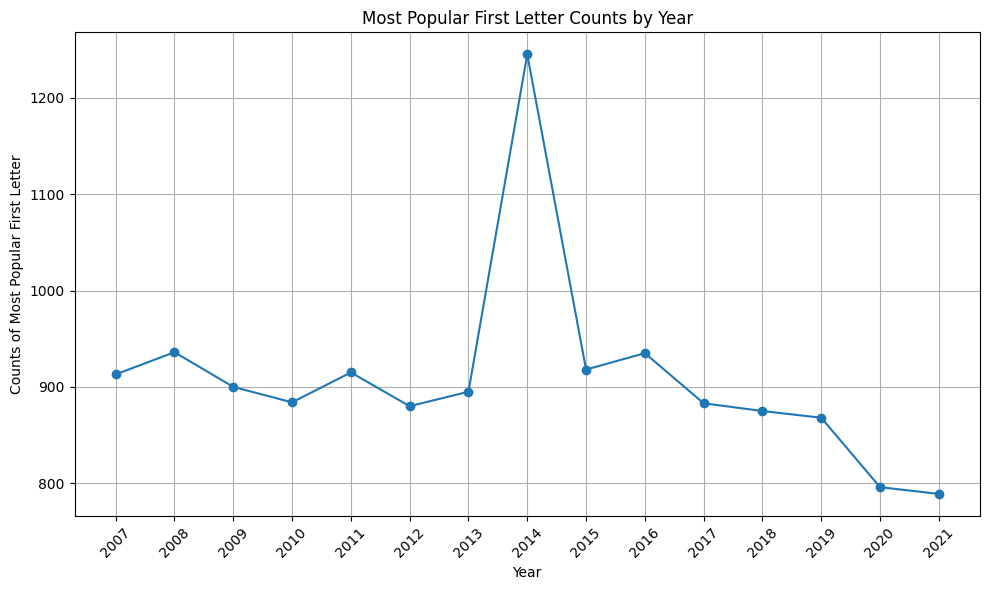

In [0]:
import matplotlib.pyplot as plt

# Assuming 'most_popular_letters' is your DataFrame from the last step
plt.figure(figsize=(10, 6))
plt.plot(most_popular_letters['year'], most_popular_letters['counts'], marker='o')
plt.title('Most Popular First Letter Counts by Year')
plt.xlabel('Year')
plt.ylabel('Counts of Most Popular First Letter')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Challenge III
---

### MLE SYSTEM DESIGN
###### Problem

At NBrown, we are obsessed with our customers and strive to provide the highest level of customer satisfaction. Growing our customer base is a key focus, and we utilise churn rate as one of our primary metrics.

Our Marketing Services department is responsible for creating ads that target customers who are predicted to unsubscribe from our services within the next three months. To enhance this effort, the business aims to integrate machine learning into its marketing strategy. The data science team has developed a model capable of predicting customer churn rates that needs to be accessed by the marketing team.

As a Machine Learning Engineer, you are tasked with productionising this model and documenting the process you would follow.
Can you conceptualise a solution that meets the following requirements:

1. Provide a system diagram that illustrates the cloud architecture. We ideally want AWS or Google Cloud but you may use a cloud platform of your choice.
2. Explain how the work will transition from data science research to a production environment.

This task is designed to be open-ended to give us insight into your approach to the solution.
We understand the constraints of balancing this task with other commitments thus expect you to spend approximately 1.5 hours on this task.
You should send back an written explanation on no morethan one page not including the system design diagram(s)

We look forward to seeing your solution. Thank you for your time and effort.

Challenge 
The productionizing a customer churn prediction model for NBrown, it's essential to design a system that efficiently integrates machine learning into the existing marketing strategy. The system should enable the Marketing Services department to access the model predictions effectively for targeting customers at risk of churning. In the below the particular solution makes use of the AWS as the cloud platform. This approach might be a quite complicated. 

### Solution Overview

The solution involves several key components:
1. **Model Training Environment**: An environment where the data science team can experiment, train, and validate the churn prediction model.
2. **Model Deployment**: A robust mechanism to deploy the trained model for inference.
3. **Data Pipeline**: A pipeline for data ingestion, processing, and feeding into the model.
4. **Model Access Layer**: Interfaces for the marketing team to access the model predictions.

### System Diagram and Components

The system can be conceptualized with the following AWS components:

1. **Amazon S3**: Stores raw data, processed data, and model artifacts.
2. **AWS Lambda / AWS Fargate**: For running data processing jobs that prepare data for model training and predictions.
3. **Amazon SageMaker**: For model training, tuning, and deployment. Provides an HTTPS endpoint for model access.
4. **Amazon API Gateway**: To create RESTful APIs for the marketing team to access the predictions securely.
5. **AWS Step Functions**: Orchestrate data workflows, ensuring that data processing and model inference jobs run in the correct sequence and handle failures gracefully.
6. **Amazon RDS / Amazon DynamoDB**: To store operational data like user profiles and prediction logs.
7. **Amazon CloudWatch**: For monitoring the operations of all components, including model performance monitoring and logging.

### Transition from Research to Production

#### Step 1: Model Development and Validation
- The data science team develops the churn prediction model using historical data stored in Amazon S3.
- Use Amazon SageMaker for exploratory data analysis, feature engineering, model training, and validation.

#### Step 2: Model Deployment
- Once the model is trained and validated, it's deployed as a SageMaker endpoint. This endpoint serves real-time predictions and can scale depending on request volumes.
- Model versioning is managed to rollback if needed.

#### Step 3: Data Pipeline Setup
- Data pipelines are set up using AWS Lambda or AWS Fargate to process incoming data, ensuring it's formatted correctly for the model.
- Processed data is stored in S3 and loaded into the model for scoring.

#### Step 4: Integration and Access Layer
- An API Gateway is set up to provide a secure, scalable way for the marketing team to access model predictions.
- The marketing team can send requests with customer data to the API, receive predictions, and target customers accordingly.

#### Step 5: Monitoring and Maintenance
- Use Amazon CloudWatch to monitor the system's performance, including API usage, latency, and model performance.
- Regular updates and retraining of the model based on new data and feedback to ensure accuracy remains high.

### Documentation and Best Practices
- Document all processes, including data handling, model training parameters, API usage, and error handling.
- Implement best practices for security, including data encryption (at rest and in transit), secure API access, and compliance with data protection regulations.

Aprat from this there is one more solution way where we can use the Google cloud aswell, in order to perform the same this and this are the stpes as well can follow:

Using Google Cloud Platform (GCP), which also offers robust services for deploying machine learning models and managing data workflows efficiently. This alternative will focus on simplicity and direct integration with marketing tools, leveraging GCP’s serverless computing capabilities and AI Platform.

### Solution Overview

The architecture on GCP will emphasize streamlined data flows, automated model retraining, and direct integration with marketing campaign management tools via APIs.

### System Diagram and Components

**Key Components:**

1. **Google Cloud Storage (GCS)**: To store raw and processed data, as well as model artifacts.
2. **BigQuery**: For managing large datasets, performing SQL-based data transformations, and operational analytics.
3. **Cloud Functions / Cloud Run**: For lightweight, event-driven processing tasks such as data preprocessing and post-prediction actions.
4. **AI Platform**: For training, deploying, and managing machine learning models. Provides automatic scaling for prediction endpoints.
5. **Cloud Endpoints**: To expose the ML model via RESTful API to marketing tools and internal users.
6. **Pub/Sub and Dataflow**: For handling streaming data, orchestrating workflows, and ensuring data is timely processed and fed into the model.
7. **Cloud Scheduler**: To manage routine tasks like model retraining and data updates.
8. **Operations Suite (formerly Stackdriver)**: For monitoring, logging, and alerting to ensure operational health and performance insights.

### Transition from Research to Production

#### Step 1: Data and Model Development
- Utilize BigQuery for exploratory data analysis and preprocessing using SQL queries. Leverage the scalable nature of BigQuery to handle large volumes of data efficiently.
- Train the model using AI Platform, exploring different algorithms suitable for churn prediction.

#### Step 2: Model Deployment
- Deploy the trained model to AI Platform Predictions, which provides a managed environment for deploying ML models into production with auto-scaling capabilities.
- Create versioned model endpoints to manage different iterations of the model seamlessly.

#### Step 3: Data Pipeline Automation
- Set up data ingestion workflows with Pub/Sub for real-time data and Cloud Storage for batch data uploads.
- Use Dataflow to preprocess data streams/batches to ensure they are model-ready. Implement Cloud Functions or Cloud Run for lightweight tasks.

#### Step 4: API and Integration Layer
- Deploy Cloud Endpoints to create and manage APIs that the marketing team and other systems can consume. This serves as a secure gateway to invoke the AI model predictions.
- Integrate API outputs directly into marketing tools using webhook triggers or direct API calls.

#### Step 5: Monitoring and Continuous Improvement
- Use GCP’s Operations Suite to monitor the health of all components, track model performance, and set up alerts for anomalies.
- Schedule regular model evaluations and retraining using Cloud Scheduler to ensure the model adapts to new data and changing patterns.

### Documentation and Compliance
- Maintain comprehensive documentation for all workflows, data schemas, and API usage guidelines.
- Ensure compliance with relevant data privacy laws (e.g., GDPR, CCPA) by implementing necessary data handling and security measures.

### Conclusion

This GCP-based solution aims to harness the power of serverless computing and managed services to reduce the operational overhead for NBrown’s IT and data science teams. It focuses on automating as much of the operational workflow as possible, from data ingestion to model retraining and prediction serving, providing a robust, scalable infrastructure that can adapt to changing business needs and data volumes. This approach also ensures that the marketing team has near-real-time access to predictive insights, enabling dynamic and effective customer retention strategies.